# **Contradictory, My Dear Watson - NLP using BERT**

In [1]:
import numpy as np 
import pandas as pd 
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt 

2023-02-13 19:54:38.108433: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-13 19:54:38.108555: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train_df = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")

In [3]:
train_df.sample(8)

,id,premise,hypothesis,lang_abv,language,label
11504,96add82587,JEDWALI A.- JUMLA YA POSHO ZA ZEBAKI IMETENGWA...,Hakuna kanuni kuhusu zebaki.,sw,Swahili,2
6342,7a6a71a19f,The other bank pays the fund interest based up...,The fund account has five different tiers.,en,English,1
1367,bd45b6d2ac,Ukweli ni kwamba majadiliano ya msalaba yanawe...,Majadiliano huwa hayapo.,sw,Swahili,2
2854,13f55cfb75,"Around the year 1400, fighting over the island...",There was fighting over Singapore.,en,English,0
7295,79976cc979,well that would be a help i wish they would do...,We have plenty of space in the landfill.,en,English,2
3921,f846dcf7ad,for the direct sunlight and stuff right but uh...,I've had to paint every year.,en,English,2
795,a40f4bcf12,The tree-lined avenue extends less than three ...,You must travel two miles via the avenue to th...,en,English,2
11305,2bca4e7939,"Той също така заяви, че Ата е включвала ядрена...",Ядрената централа бе премахната от списъка с н...,bg,Bulgarian,1


In [4]:
train_df.shape

(12120, 6)

In [5]:
train_df.language.unique(), train_df.language.nunique()

(array(['English', 'French', 'Thai', 'Turkish', 'Urdu', 'Russian',
        'Bulgarian', 'German', 'Arabic', 'Chinese', 'Hindi', 'Swahili',
        'Vietnamese', 'Spanish', 'Greek'], dtype=object),
 15)

In [6]:
train_df["label"].value_counts()

0    4176
2    4064
1    3880
Name: label, dtype: int64

**labels of 0, 1, or 2 corresponds to entailment, neutral, and contradiction**

In [7]:
train_df.premise.values[0],train_df.hypothesis.values[0]
# Entailment example

('and these comments were considered in formulating the interim rules.',
 'The rules developed in the interim were put together with these comments in mind.')

In [8]:
train_df.premise.values[1],train_df.hypothesis.values[1]
# Contradiction example

('These are issues that we wrestle with in practice groups of law firms, she said. ',
 'Practice groups are not permitted to work on these issues.')

In [9]:
train_df.premise.values[3576],train_df.hypothesis.values[3576]
# Neutral example

('The Celts arrived in the wake of the Roman withdrawal at the end of the fourth century.',
 'At the end of the fourth century was when baked goods flourished.')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


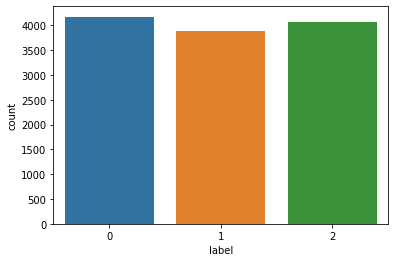

In [10]:
ax = sns.countplot(train_df.label)
entailment,neutral,contradiction = train_df.label.value_counts();

In [11]:
print('The number of entries for the entailment class is:', entailment)
print('The number of trials for the neutral class is:', neutral)
print('The number of trials for the contradiction class is:', contradiction)

The number of entries for the entailment class is: 4176
The number of trials for the neutral class is: 4064
The number of trials for the contradiction class is: 3880


In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [13]:
def encoded_sentence(text):
    encoded_input = tokenizer(text)
    return encoded_input

In [14]:
output = encoded_sentence("This competition is for kaggle beginners.")
output

{'input_ids': [101, 10747, 16622, 10124, 10142, 10730, 21127, 10284, 16135, 34663, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [15]:
def inputidstypes_sentence(premise,hypothesis):
    output = encoded_sentence(premise)
    input_ids = output['input_ids']
    input_types = output['token_type_ids']
    hypothesis_tokens = list(tokenizer.tokenize(hypothesis))
    hypothesis_tokens.append('[SEP]')
    hypothesis_ids = tokenizer.convert_tokens_to_ids(hypothesis_tokens)
    input_types.extend([1] * len(hypothesis_tokens))
    input_ids.extend(hypothesis_ids)
    return input_ids,input_types

In [16]:
#example 
text1 = "My name is Beyda."
text2 = "This is my project."
ids,types = inputidstypes_sentence(text1,text2)
print(ids,types)

[101, 11590, 11324, 10124, 40344, 10229, 119, 102, 10747, 10124, 15127, 13920, 119, 102] [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]


In [17]:
def model_input(premises,hypotheses):
    
    num_examples = len(hypotheses)
    print(num_examples)

    input_ids = list()
    input_types = list()
    
    for premise,hypothesis in zip(premises,hypotheses):
        input_id,input_type = inputidstypes_sentence(premise,hypothesis)
        input_ids.append(input_id)
        input_types.append(input_type)
        
    print(len(input_ids))
    print(len(input_types))
    input_words_ids =  tf.ragged.constant(input_ids)
    input_types_ids = tf.ragged.constant(input_types)
    input_mask = tf.ones_like(input_words_ids).to_tensor(shape=[num_examples, 259])
    print(input_words_ids.get_shape())

    inputs = {
      'input_word_ids': input_words_ids.to_tensor(shape=[num_examples, 259]),
      'input_mask': input_mask,
      'input_type_ids': input_types_ids.to_tensor(shape=[num_examples, 259])}
    
    return inputs

In [18]:
xtrain = model_input(train_df.premise,train_df.hypothesis)
xtrain

12120
12120
12120


2023-02-13 19:54:59.797100: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-13 19:54:59.799864: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-13 19:54:59.799900: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-13 19:54:59.799938: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (97f1e5fec59f): /proc/driver/nvidia/version does not exist
2023-02-13 19:54:59.805669: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

(12120, None)


{'input_word_ids': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[  101, 10111, 11762, ...,     0,     0,     0],
        [  101, 13252, 10301, ...,     0,     0,     0],
        [  101, 13810, 32181, ...,     0,     0,     0],
        ...,
        [  101, 10117, 12452, ...,     0,     0,     0],
        [  101, 11699, 10105, ...,     0,     0,     0],
        [  101, 11399, 14764, ...,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 

In [19]:
xtrain['input_word_ids']

<tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
array([[  101, 10111, 11762, ...,     0,     0,     0],
       [  101, 13252, 10301, ...,     0,     0,     0],
       [  101, 13810, 32181, ...,     0,     0,     0],
       ...,
       [  101, 10117, 12452, ...,     0,     0,     0],
       [  101, 11699, 10105, ...,     0,     0,     0],
       [  101, 11399, 14764, ...,     0,     0,     0]], dtype=int32)>

In [20]:
max_len = 259
def build_model():
    bert_encoder = TFBertModel.from_pretrained("bert-base-multilingual-cased")
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

Flip the "Accelerator" switch in your notebook to "TPU v3-8"

In [22]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

2023-02-13 19:55:31.367591: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2023-02-13 19:55:31.367671: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2023-02-13 19:55:31.385727: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2023-02-13 19:55:31.385783: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2023-02-13 19:55:31.386366: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:411] Started server with target: grpc://localhost:30020


In [23]:
with strategy.scope():
    model = build_model()
    model.summary()

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 259)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 259)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 259)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [24]:
model.fit(xtrain, train_df.label.values, epochs = 10, verbose = 1, batch_size = 64, validation_split = 0.2)

Epoch 1/10
152/152 [==============================] - 151s 519ms/step - loss: 1.1083 - accuracy: 0.3989 - val_loss: 0.8543 - val_accuracy: 0.6056
Epoch 2/10
152/152 [==============================] - 19s 127ms/step - loss: 0.7879 - accuracy: 0.6569 - val_loss: 0.8007 - val_accuracy: 0.6440
Epoch 3/10
152/152 [==============================] - 20s 128ms/step - loss: 0.6333 - accuracy: 0.7352 - val_loss: 0.8445 - val_accuracy: 0.6485
Epoch 4/10
152/152 [==============================] - 19s 127ms/step - loss: 0.4580 - accuracy: 0.8252 - val_loss: 0.9168 - val_accuracy: 0.6436
Epoch 5/10
152/152 [==============================] - 19s 127ms/step - loss: 0.3208 - accuracy: 0.8812 - val_loss: 1.1086 - val_accuracy: 0.6477
Epoch 6/10
152/152 [==============================] - 19s 128ms/step - loss: 0.2310 - accuracy: 0.9210 - val_loss: 1.2624 - val_accuracy: 0.6411
Epoch 7/10
152/152 [==============================] - 19s 128ms/step - loss: 0.1677 - accuracy: 0.9423 - val_loss: 1.4174 - val_a

In [25]:
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
test_input = model_input(test.premise.values, test.hypothesis.values)

5195
5195
5195
(5195, None)


In [26]:
test.shape

(5195, 5)

In [27]:
test.head(10)

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian
5,aa2510d454,His family had lost a son and a daughter now.,The son and daughter had lost their father.,en,English
6,865d1c7b16,Steps are initiated to allow program board mem...,There's enough room for 35-40 positions on the...,en,English
7,a16f7ed56b,C'était probablement la première chose dont je...,C'était l'un de mes premiers souvenirs.,fr,French
8,6d9fa191e6,"agencies' operating trust, enterprise and inte...",Agencies in financial trouble are usually audi...,en,English
9,c156e8fed5,Hakuna aliyejua walipokwenda.,Mafiko yao ilikuwa ni siri,sw,Swahili


In [28]:
predictions = [np.argmax(i) for i in model.predict(test_input)]

In [29]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions

In [30]:
submission.head(10)

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,0
4,c32b0d16df,0
5,aa2510d454,0
6,865d1c7b16,1
7,a16f7ed56b,0
8,6d9fa191e6,1
9,c156e8fed5,0


In [31]:
submission.to_csv("submission.csv", index = False)